# Data Augmentation Effect on Fine-Tuning VGG16 and ResNet50 for Image Classification

In this notebook, we will show the effect of data augmentation on fine-tuning VGG16 and ResNet50 for image classification. I will use a sample dataset of cats and dogs images. The dataset is available at [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data). 

## Introduction

Fine-tuning is a transfer learning technique that allows us to use a pre-trained model as a starting point for a new task. The idea is to leverage the knowledge learned by the pre-trained model on a new dataset. This is particularly useful when we have a small dataset. Data augmentation is a technique used to artificially increase the size of the training dataset by applying random transformations to the original images. This helps to improve the generalization of the model. We will show the effect of data augmentation on fine-tuning VGG16 and ResNet50 for image classification.

## Pre-Implementation

In [1]:
import os
import cv2
import numpy as np
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50
from keras.models import Sequential, Model, model_from_json
from keras import layers as Layers

np.random.RandomState(7)

RandomState(MT19937) at 0x16419228D40

In [2]:
def read_images_of(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            image = image / 255.0
            if image is not None:
                images.append(image)
    images = np.array(images)
    return images


cats_train = read_images_of("../data/fine-tuning/Train/Cats")
cats_test = read_images_of("../data/fine-tuning/Test/Cats")
dogs_train = read_images_of("../data/fine-tuning/Train/Dogs")
dogs_test = read_images_of("../data/fine-tuning/Test/Dogs")

Then for labeling the images, we will use the one-hot encoding technique. One-hot encoding is a technique used to convert categorical data into a binary matrix. Each row in the matrix corresponds to a sample, and each column corresponds to a class. The column

In [3]:
encoder = OneHotEncoder(sparse_output=False)

train_data = np.concatenate((cats_train, dogs_train), axis=0)
cats_label = np.ones(cats_train.shape[0], dtype=int)
dogs_label = np.zeros(dogs_train.shape[0], dtype=int)
train_labels = np.concatenate((cats_label, dogs_label), axis=0).reshape(-1, 1)


shuffle_indices = np.random.permutation(train_data.shape[0])
train_data = train_data[shuffle_indices]
train_labels = train_labels[shuffle_indices]
train_labels = encoder.fit_transform(train_labels)


test_data = np.concatenate((cats_test, dogs_test), axis=0)
cats_label = np.ones(cats_test.shape[0], dtype=int)
dogs_label = np.zeros(dogs_test.shape[0], dtype=int)
test_labels = np.concatenate((cats_label, dogs_label), axis=0).reshape(-1, 1)

shuffle_indices = np.random.permutation(test_data.shape[0])
test_data = test_data[shuffle_indices]
test_labels = test_labels[shuffle_indices]
test_labels = encoder.fit_transform(test_labels)


We use 70-30% training and validation split. We will use the training set to fine-tune the pre-trained models and the validation set to evaluate the performance of the models.

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.3, random_state=7)

In [5]:
def plot_metrics(history):

    fig, axs = plt.subplots(2, 1, figsize=(8, 8))

    axs[0].plot(history.history["loss"], label="Training Loss")
    axs[0].plot(history.history["val_loss"], label="Validation Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(history.history["accuracy"], label="Training Accuracy")
    axs[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

For Data Augmentation, we will use the following transformations:
- Random Rotation up tp 30 degrees
- Horizontal Flip
- Zoom from 0.75 to 1.25

In [6]:
train_datagen = ImageDataGenerator(
    horizontal_flip = True, 
    rotation_range = 30, 
    zoom_range = (0.75, 1.25)
).flow(
    x = X_train, 
    y = y_train, 
    batch_size=10
)


valid_datagen = ImageDataGenerator().flow(
    x = X_valid, 
    y = y_valid, 
    batch_size = 10
)

In [7]:
def evaluate_test(model):
    with tf.device("/cpu:0"):
        y_pred = model.predict(test_data)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(test_labels, axis=1)
        acc = np.mean(y_true == y_pred)
        print(acc)

In [8]:
def layer_specific_summary(model):
    for i, layer in enumerate(model.layers):
        print(i, layer.name, layer.trainable)

In [9]:
def save_weights(model, weights_path):
    model.save_weights(weights_path)
    print("Saved model to disk")


def load_weights(model, weights_path: str):
    model.load_weights(weights_path)
    print("Loaded model from disk")

    return model

def save_model(model, model_path, weights_path):
    model_json = model.to_json()
    with open(model_path, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(weights_path)
    print("Saved model to disk")

def load_model(model_path, weights_path):
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(weights_path)
    print("Loaded model from disk")

    return model

For optimization, we will use the SGD optimizer with a learning rate of 0.0001 and a momentum of 0.9. We will train the model for 50 epochs with a batch size of 32. The formula for the learning rate is given by:

$$ lr = lr * 1/(1 + decay * epoch) $$

where lr is the initial learning rate, decay is the learning rate decay, and epoch is the current epoch.

The formula for SGD with momentum is given by:

$$ w = w - lr * dw $$

where w is the weight, lr is the learning rate, and dw is the gradient of the weight.

In [10]:
def scheduler(epoch, lr):
    decay_rate = 0.002
    new_lr = lr / (1.0 + decay_rate * epoch)
    return new_lr

LR_sched = keras.callbacks.LearningRateScheduler(scheduler)    

**VGG16**

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition". The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It is a simple and widely used model for image classification. The model consists of 13 convolutional layers and 3 fully connected layers. The model is pre-trained on the ImageNet dataset.


In [12]:
def create_model_vgg16():
    cnn_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    model = Sequential()
    model.add(cnn_base)
    model.add(Layers.Flatten())
    model.add(Layers.Dense(512, activation="relu"))
    model.add(Layers.Dropout(0.5))
    model.add(Layers.Dense(128, activation="relu"))
    model.add(Layers.Dropout(0.3))
    model.add(Layers.Dense(2, activation="softmax"))
    
    return cnn_base, model

**ResNet50**

ResNet50 is a convolutional neural network model proposed by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun from Microsoft Research in the paper "Deep Residual Learning for Image Recognition". The model achieves 92.2% top-5 test accuracy in ImageNet. The model is pre-trained on the ImageNet dataset. The model consists of 50 convolutional layers. The model introduces the concept of residual learning, which helps to train very deep neural networks. The model is widely used for image classification. 

In [17]:
def create_model_resnet50():
    cnn_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    x = (Layers.GlobalAveragePooling2D())(cnn_base.output)
    x = (Layers.BatchNormalization())(x)
    output = (Layers.Dense(2, activation="softmax"))(x)
    
    model = Model(inputs=cnn_base.input, outputs=output)
    return cnn_base, model

## VGG16 Base 

In [18]:
cnn_base, model = create_model_vgg16()

cnn_base.trainable = False
model.summary(show_trainable=True)

Model: "sequential_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  N          
                                                                            
 flatten_2 (Flatten)         (None, 25088)             0         Y          
                                                                            
 dense_6 (Dense)             (None, 512)               12845568  Y          
                                                                            
 dropout_4 (Dropout)         (None, 512)               0         Y          
                                                                            
 dense_7 (Dense)             (None, 128)               65664     Y          
                                                                            
 dropout_5 (Dropout)         (None, 128)              

In [15]:
optimizer = keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

with tf.device("/gpu:0"):
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=15,
        batch_size=10,
        validation_data=valid_datagen,
        callbacks=[LR_sched],
    )

Epoch 1/15
50/50 [==============================] - 13s 105ms/step - loss: 0.8864 - accuracy: 0.4888 - val_loss: 0.7151 - val_accuracy: 0.5071 - lr: 2.0000e-05
Epoch 2/15
50/50 [==============================] - 4s 88ms/step - loss: 0.7763 - accuracy: 0.5458 - val_loss: 0.6452 - val_accuracy: 0.6540 - lr: 1.9960e-05
Epoch 3/15
50/50 [==============================] - 4s 88ms/step - loss: 0.7322 - accuracy: 0.5458 - val_loss: 0.6134 - val_accuracy: 0.7299 - lr: 1.9881e-05
Epoch 4/15
50/50 [==============================] - 4s 89ms/step - loss: 0.6799 - accuracy: 0.6212 - val_loss: 0.6052 - val_accuracy: 0.7441 - lr: 1.9762e-05
Epoch 5/15
50/50 [==============================] - 5s 98ms/step - loss: 0.6407 - accuracy: 0.6151 - val_loss: 0.6165 - val_accuracy: 0.6635 - lr: 1.9605e-05
Epoch 6/15
50/50 [==============================] - 5s 94ms/step - loss: 0.6430 - accuracy: 0.6395 - val_loss: 0.5675 - val_accuracy: 0.7867 - lr: 1.9411e-05
Epoch 7/15
50/50 [==============================] 

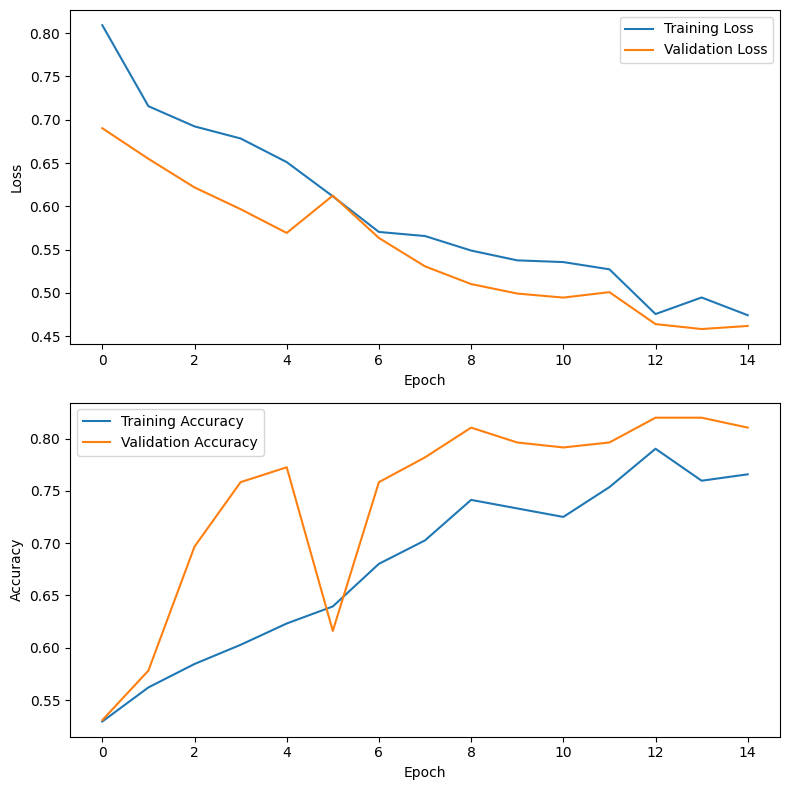

In [34]:
plot_metrics(history)

In [16]:
evaluate_test(model)

4/4 [==============================] - 9s 2s/step
0.82


In [17]:
save_weights(model, weights_path="../models/base_model_vgg16.keras")

Saved model to disk


## VGG16 without Data Augmentation

In [12]:
cnn_base, model = create_model_vgg16()
load_weights(model, weights_path="../models/base_model_vgg16.keras")

Loaded model from disk


In [13]:
cnn_base.trainable = True

set_trainable = False
for layer in cnn_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2

In [44]:
optimizer = keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

with tf.device("/gpu:0"):
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=50,
        batch_size=10,
        validation_data=valid_datagen,
        callbacks=[LR_sched],
    )

Epoch 1/50
50/50 [==============================] - 6s 108ms/step - loss: 0.4713 - accuracy: 0.8065 - val_loss: 0.4309 - val_accuracy: 0.8341 - lr: 2.0000e-05
Epoch 2/50
50/50 [==============================] - 5s 106ms/step - loss: 0.4308 - accuracy: 0.8228 - val_loss: 0.4044 - val_accuracy: 0.8436 - lr: 1.9960e-05
Epoch 3/50
50/50 [==============================] - 5s 101ms/step - loss: 0.3990 - accuracy: 0.8248 - val_loss: 0.3894 - val_accuracy: 0.8578 - lr: 1.9881e-05
Epoch 4/50
50/50 [==============================] - 5s 101ms/step - loss: 0.4215 - accuracy: 0.8167 - val_loss: 0.3830 - val_accuracy: 0.8626 - lr: 1.9762e-05
Epoch 5/50
50/50 [==============================] - 5s 101ms/step - loss: 0.4137 - accuracy: 0.8310 - val_loss: 0.3745 - val_accuracy: 0.8436 - lr: 1.9605e-05
Epoch 6/50
50/50 [==============================] - 5s 102ms/step - loss: 0.3735 - accuracy: 0.8615 - val_loss: 0.3558 - val_accuracy: 0.8578 - lr: 1.9411e-05
Epoch 7/50
50/50 [============================

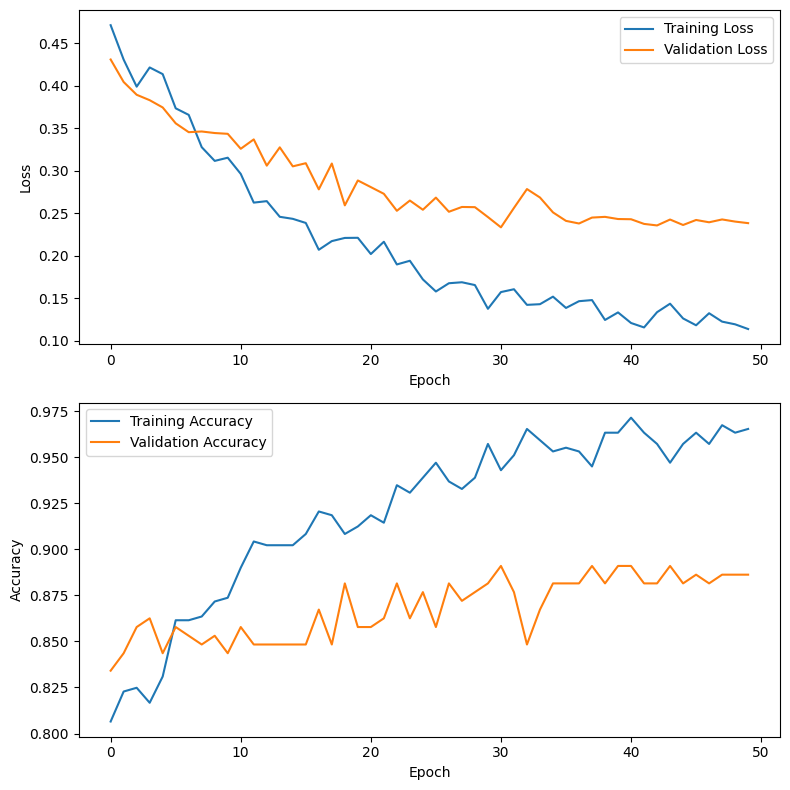

In [45]:
plot_metrics(history)

In [46]:
evaluate_test(model)

4/4 [==============================] - 8s 2s/step
0.92


## VGG16 with Data Augmentation

In [20]:
cnn_base, model = create_model_vgg16()
model = load_weights(model, weights_path="../models/base_model_vgg16.keras")

Loaded model from disk


In [21]:
cnn_base.trainable = True

set_trainable = False
for layer in cnn_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 2)                

In [49]:
optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device("/gpu:0"):
    history = model.fit(
        x = train_datagen,
        epochs = 50,
        steps_per_epoch = 50,
        validation_data = valid_datagen,
        callbacks = [LR_sched]
    )

Epoch 1/50
50/50 [==============================] - 6s 111ms/step - loss: 0.6062 - accuracy: 0.6721 - val_loss: 0.5104 - val_accuracy: 0.7299 - lr: 1.0000e-04
Epoch 2/50
50/50 [==============================] - 5s 106ms/step - loss: 0.5587 - accuracy: 0.7006 - val_loss: 0.4160 - val_accuracy: 0.8009 - lr: 9.9800e-05
Epoch 3/50
50/50 [==============================] - 5s 105ms/step - loss: 0.5156 - accuracy: 0.7617 - val_loss: 0.3590 - val_accuracy: 0.8578 - lr: 9.9403e-05
Epoch 4/50
50/50 [==============================] - 5s 107ms/step - loss: 0.4394 - accuracy: 0.7841 - val_loss: 0.5736 - val_accuracy: 0.7062 - lr: 9.8810e-05
Epoch 5/50
50/50 [==============================] - 6s 111ms/step - loss: 0.4507 - accuracy: 0.7882 - val_loss: 0.2889 - val_accuracy: 0.8768 - lr: 9.8026e-05
Epoch 6/50
50/50 [==============================] - 5s 106ms/step - loss: 0.3762 - accuracy: 0.8473 - val_loss: 0.2684 - val_accuracy: 0.8815 - lr: 9.7055e-05
Epoch 7/50
50/50 [============================

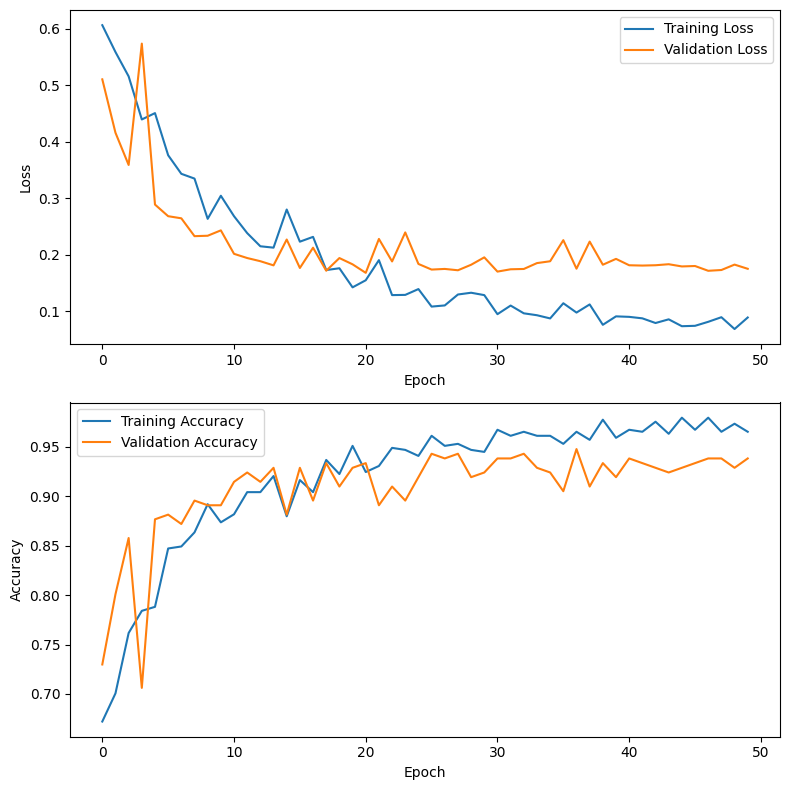

In [50]:
plot_metrics(history)

In [51]:
evaluate_test(model)

4/4 [==============================] - 6s 1s/step
0.94


## ResNet50 Base

In [19]:
cnn_base, model = create_model_resnet50()

cnn_base.trainable = False

for layer in cnn_base.layers:
    if layer.name.endswith("bn"):
        layer.trainable = True

layer_specific_summary(model)

0 input_4 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn True
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn True
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn True
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn True
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn True
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn True
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn True
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn True
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn True
37 conv2_block3_add False
38 conv2_block3_out Fals

In [23]:
optimizer = keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

with tf.device("/gpu:0"):
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=50,
        batch_size=10,
        validation_data=(X_valid, y_valid),
        callbacks=[LR_sched],
    )

Epoch 1/25
50/50 [==============================] - 7s 87ms/step - loss: 0.9724 - accuracy: 0.5356 - val_loss: 0.7362 - val_accuracy: 0.4692 - lr: 2.0000e-05
Epoch 2/25
50/50 [==============================] - 3s 65ms/step - loss: 0.7028 - accuracy: 0.6110 - val_loss: 0.7472 - val_accuracy: 0.4692 - lr: 1.9960e-05
Epoch 3/25
50/50 [==============================] - 3s 69ms/step - loss: 0.5584 - accuracy: 0.7251 - val_loss: 0.7915 - val_accuracy: 0.4645 - lr: 1.9881e-05
Epoch 4/25
50/50 [==============================] - 3s 69ms/step - loss: 0.4792 - accuracy: 0.7576 - val_loss: 1.3291 - val_accuracy: 0.4692 - lr: 1.9762e-05
Epoch 5/25
50/50 [==============================] - 3s 68ms/step - loss: 0.4202 - accuracy: 0.8228 - val_loss: 1.9108 - val_accuracy: 0.4692 - lr: 1.9605e-05
Epoch 6/25
50/50 [==============================] - 3s 65ms/step - loss: 0.4054 - accuracy: 0.8045 - val_loss: 2.1883 - val_accuracy: 0.4739 - lr: 1.9411e-05
Epoch 7/25
50/50 [==============================] - 

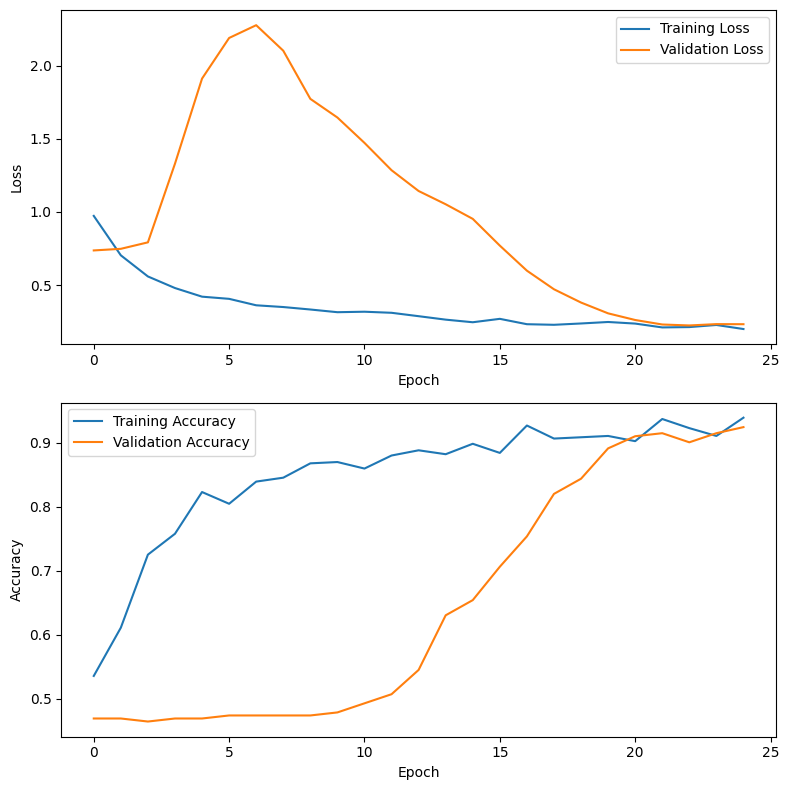

In [24]:
plot_metrics(history)

In [25]:
evaluate_test(model)

4/4 [==============================] - 5s 894ms/step
0.89


In [28]:
save_model(model, model_path='../models/resnet50_model.json', weights_path="../models/base_model_resnet50.keras")

Saved model to disk


## ResNet50 without Data Augmentation

In [22]:
cnn_base, model = create_model_resnet50()

In [24]:
cnn_base.trainable = True
set_trainable = False
for layer in cnn_base.layers:
    if layer.name == "conv5_block3_3_conv":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in model.layers:
    if layer.name.endswith("bn"):
        layer.trainable = True

# model.summary()
layer_specific_summary(model)

0 input_6 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn True
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn True
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn True
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn True
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn True
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn True
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn True
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn True
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn True
37 conv2_block3_add False
38 conv2_block3_out Fals

Epoch 1/50
50/50 [==============================] - 20s 169ms/step - loss: 0.9147 - accuracy: 0.5540 - val_loss: 0.9821 - val_accuracy: 0.4834 - lr: 2.0000e-05
Epoch 2/50
50/50 [==============================] - 7s 141ms/step - loss: 0.5698 - accuracy: 0.7149 - val_loss: 0.9137 - val_accuracy: 0.4834 - lr: 1.9960e-05
Epoch 3/50
50/50 [==============================] - 7s 142ms/step - loss: 0.4648 - accuracy: 0.7800 - val_loss: 0.7486 - val_accuracy: 0.5118 - lr: 1.9881e-05
Epoch 4/50
50/50 [==============================] - 7s 141ms/step - loss: 0.3732 - accuracy: 0.8228 - val_loss: 1.3664 - val_accuracy: 0.5166 - lr: 1.9762e-05
Epoch 5/50
50/50 [==============================] - 7s 142ms/step - loss: 0.3021 - accuracy: 0.8676 - val_loss: 1.7657 - val_accuracy: 0.5166 - lr: 1.9605e-05
Epoch 6/50
50/50 [==============================] - 7s 142ms/step - loss: 0.2612 - accuracy: 0.8880 - val_loss: 1.7458 - val_accuracy: 0.5213 - lr: 1.9411e-05
Epoch 7/50
50/50 [===========================

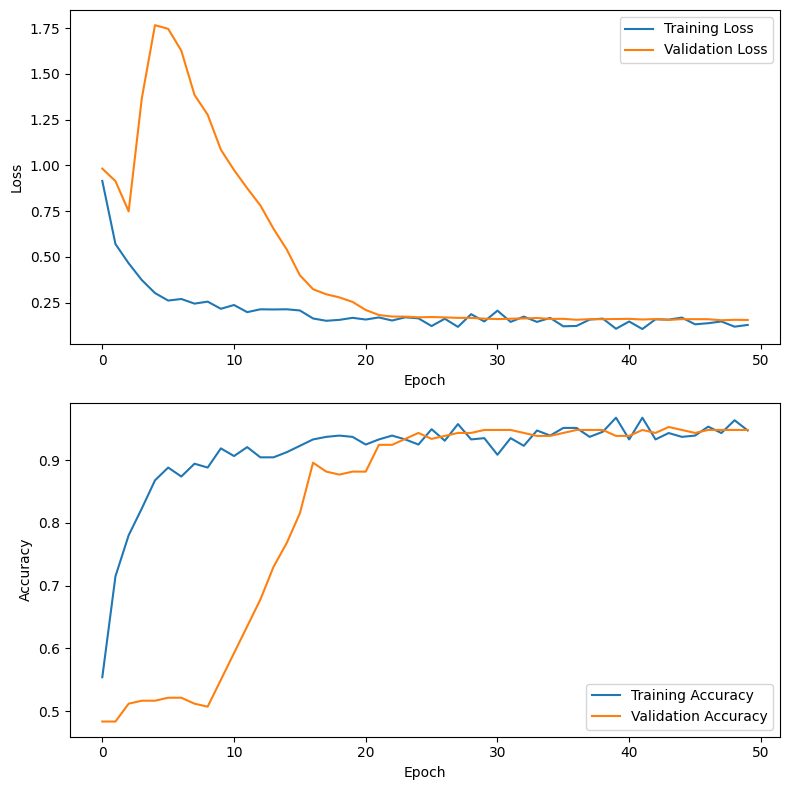

4/4 [==============================] - 7s 1s/step
0.94


In [31]:
optimizer = keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

with tf.device("/gpu:0"):
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=50,
        batch_size=10,
        validation_data=valid_datagen,
        callbacks=[LR_sched],
    )
    
plot_metrics(history)

evaluate_test(model)

## ResNet50 with Data Augmentation

In [25]:
cnn_base, model = create_model_resnet50()

In [26]:
cnn_base.trainable = True
set_trainable = False
for layer in cnn_base.layers:
    if layer.name == "conv5_block3_3_conv":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in model.layers:
    if layer.name.endswith("bn"):
        layer.trainable = True

layer_specific_summary(model)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn True
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn True
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn True
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn True
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn True
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn True
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn True
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn True
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn True
37 conv2_block3_add False
38 conv2_block3_out Fals

Epoch 1/50
50/50 [==============================] - 17s 168ms/step - loss: 0.8717 - accuracy: 0.5703 - val_loss: 0.9385 - val_accuracy: 0.5071 - lr: 2.0000e-05
Epoch 2/50
50/50 [==============================] - 7s 138ms/step - loss: 0.6315 - accuracy: 0.6965 - val_loss: 0.6702 - val_accuracy: 0.5924 - lr: 1.9960e-05
Epoch 3/50
50/50 [==============================] - 7s 137ms/step - loss: 0.4922 - accuracy: 0.7637 - val_loss: 0.9108 - val_accuracy: 0.3839 - lr: 1.9881e-05
Epoch 4/50
50/50 [==============================] - 7s 137ms/step - loss: 0.4294 - accuracy: 0.8004 - val_loss: 1.1867 - val_accuracy: 0.4550 - lr: 1.9762e-05
Epoch 5/50
50/50 [==============================] - 7s 139ms/step - loss: 0.3757 - accuracy: 0.8208 - val_loss: 1.7137 - val_accuracy: 0.4739 - lr: 1.9605e-05
Epoch 6/50
50/50 [==============================] - 7s 137ms/step - loss: 0.3899 - accuracy: 0.8371 - val_loss: 2.0078 - val_accuracy: 0.4645 - lr: 1.9411e-05
Epoch 7/50
50/50 [===========================

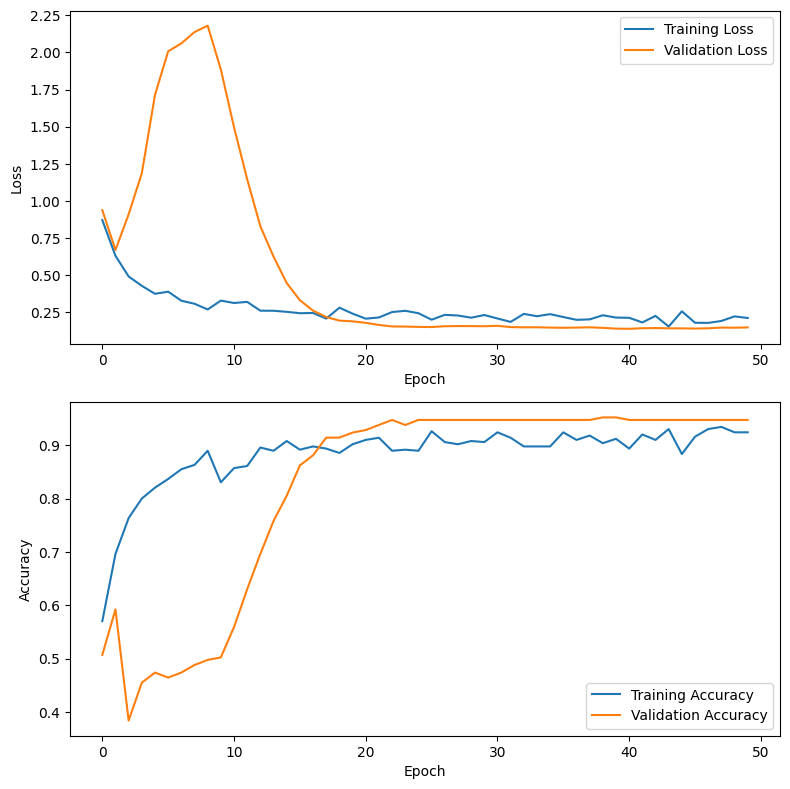

4/4 [==============================] - 7s 1s/step
0.93


In [27]:
optimizer = keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

with tf.device("/gpu:0"):
    history = model.fit(
        x=train_datagen,
        epochs=50,
        steps_per_epoch=50,
        validation_data=valid_datagen,
        callbacks=[LR_sched],
    )
    
plot_metrics(history)

evaluate_test(model)

Input Layer:

Shape: (None, 224, 224, 3)
The input layer expects images with a shape of (224, 224, 3), representing RGB images with a height and width of 224 pixels.
Convolutional Blocks:

The convolutional part of VGG16 consists of five blocks, each containing multiple convolutional layers (with 3x3 filters), followed by a max pooling layer (2x2 pool size). The number of filters increases as you go deeper into the network.

- Block 1:

    - Conv1_1: (None, 224, 224, 64)

    - Conv1_2: (None, 224, 224, 64)

    - MaxPooling1: (None, 112, 112, 64)

- Block 2:

    - Conv2_1: (None, 112, 112, 128)

    - Conv2_2: (None, 112, 112, 128)

    - MaxPooling2: (None, 56, 56, 128)

- Block 3:

    - Conv3_1: (None, 56, 56, 256)

    - Conv3_2: (None, 56, 56, 256)

    - Conv3_3: (None, 56, 56, 256)

    - MaxPooling3: (None, 28, 28, 256)

- Block 4:

    - Conv4_1: (None, 28, 28, 512)

    - Conv4_2: (None, 28, 28, 512)

    - Conv4_3: (None, 28, 28, 512)

    - MaxPooling4: (None, 14, 14, 512)

- Block 5:

    - Conv5_1: (None, 14, 14, 512)

    - Conv5_2: (None, 14, 14, 512)

    - Conv5_3: (None, 14, 14, 512)

    - MaxPooling5: (None, 7, 7, 512)
